# Data Science Hackathon
## Hackathon Topic :– Ecommerce Product Categorization

#### Data Importing and Preprocessing :-

In [3]:
# Install required packages
# !pip install wordcloud
# !pip install num2words
# !pip install pyspellchecker
# !pip install spacy
# !python -m spacy download en_core_web_sm

# Importing necessary Libraries :

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os 
import re
import nltk

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, auc,RocCurveDisplay,PrecisionRecallDisplay, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from collections import OrderedDict
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\komal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\komal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\komal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# !pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from  tensorflow.keras.utils import to_categorical
import joblib
import h5py

In [6]:
# Load the given train dataset :

df = pd.read_csv('train_product_data.csv')
df.sample()   # checking the random sample data from dataset

uniq_id            crawl_timestamp  \
12800  cfcc1eae1ceb781ab0d12c45d3042f1f  2015-12-13 00:29:55 +0000   

                                             product_url  \
12800  http://www.flipkart.com/omtex-solid-men-s-polo...   

                              product_name product_category_tree  \
12800  Omtex Solid Men's Polo Neck T-Shirt             Clothing    

                    pid  retail_price  discounted_price  \
12800  TSHE7RZJMQBJ5VR4         625.0             625.0   

                                                   image  \
12800  ["http://img6a.flixcart.com/image/t-shirt/t/t/...   

       is_FK_Advantage_product  \
12800                    False   

                                             description       product_rating  \
12800  Omtex Solid Men's Polo Neck T-Shirt\n         ...  No rating available   

            overall_rating brand  \
12800  No rating available   NaN   

                                  product_specifications  
12800  {"product_specification"=>[{"key"=>"Sleeve", "...

In [7]:
# checking the shape of train & test dataset :

print('train data = ',df.shape)

train data =  (14999, 15)


In [8]:
# save the necessary features or columns in the dataset :

df = df[['product_category_tree', 'description']]
df

product_category_tree  \
0                   Clothing    
1                   Footwear    
2                   Clothing    
3                   Clothing    
4                   Footwear    
...                       ...   
14994  Mobiles & Accessories    
14995              Jewellery    
14996  Mobiles & Accessories    
14997              Jewellery    
14998              Jewellery    

                                             description  
0      Key Features of Alisha Solid Women's Cycling S...  
1      Key Features of AW Bellies Sandals Wedges Heel...  
2      Key Features of Alisha Solid Women's Cycling S...  
3      Key Features of Alisha Solid Women's Cycling S...  
4      Key Features of dilli bazaaar Bellies, Corpora...  
...                                                  ...  
14994  TheLostPuppy Back Cover for Apple iPad Air (Mu...  
14995  Kenway Retail Brass Copper Cuff\n             ...  
14996  TheLostPuppy Back Cover for Apple iPad Air 2 (...  
14997  Kenway Retail Brass Copper Cuff\n             ...  
14998  Kenway Retail Brass Copper Cuff\n             ...  

[14999 rows x 2 columns]

In [9]:
df.shape # check the shape of data

(14999, 2)

In [10]:
# check the necessary information of the data using 'info' :

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_category_tree  14999 non-null  object
 1   description            14998 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


### Missing Values : 

In [12]:
# check either any missing value is there or not :

df.isnull().sum() / len(df) *100
# we have some null values in 'description' column 

product_category_tree    0.000000
description              0.006667
dtype: float64

In [13]:
# replace the null value with mode of 'description' column :

df['description'].fillna(df['description'].mode()[0],inplace = True)

In [14]:
# now there is no missing values in 'description' column :

df.isnull().sum() / len(df) *100

product_category_tree    0.0
description              0.0
dtype: float64

In [15]:
# check any duplicate value or not :

df.duplicated().sum()

1832

### Vizualization of target data :

In [17]:
image_folder = r"C:\Users\komal\Downloads\HACKATHON\Hackathon ANS\Image Folder"

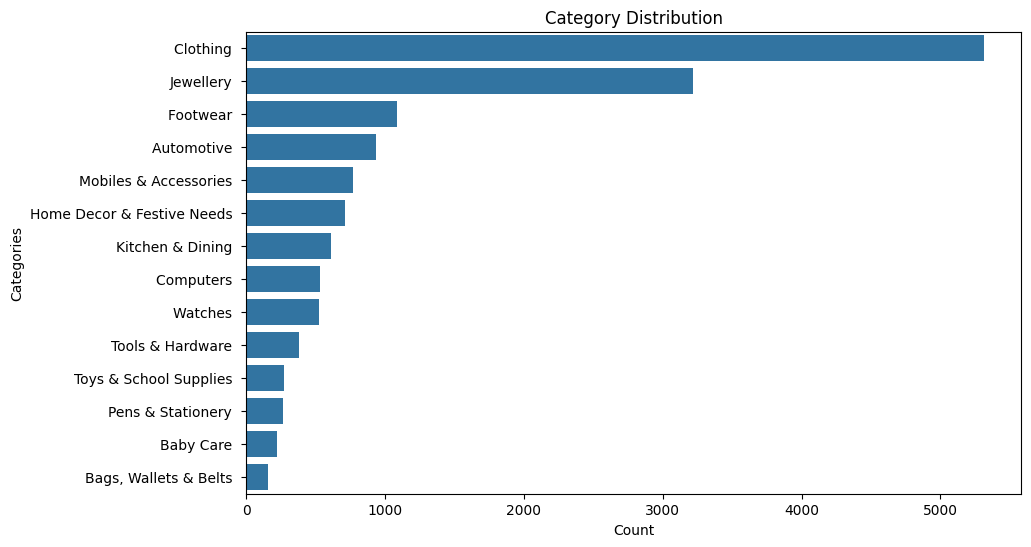

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(y="product_category_tree", data=df, order=df['product_category_tree'].value_counts().index)
plt.title('Category Distribution')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.savefig(os.path.join(image_folder, "prod_category_distribution.png"))
plt.show()

* Dataset contains more categories of “Clothing” followed by "Jewellery" and "Footwear", this implies that customers are more interested in buying this products probably female customers

### chechking , is there class is balanced or not :

In [21]:
df['product_category_tree'].value_counts()
# we see, there is imbalanced class .

product_category_tree
Clothing                       5316
Jewellery                      3218
Footwear                       1083
Automotive                      937
Mobiles & Accessories           768
Home Decor & Festive Needs      714
Kitchen & Dining                610
Computers                       531
Watches                         526
Tools & Hardware                379
Toys & School Supplies          271
Pens & Stationery               264
Baby Care                       224
Bags, Wallets & Belts           158
Name: count, dtype: int64

In [22]:
# solve the unbalanced class using 'RandomOverSampler' method :

x = df[['description']]
y = df[['product_category_tree']]

oversampler = RandomOverSampler(sampling_strategy='auto')

x_resampled, y_resampled = oversampler.fit_resample(x,y)

df_resampled = x_resampled.copy()
df_resampled['product_category_tree'] = y_resampled

print(df_resampled['product_category_tree'].value_counts())

product_category_tree
Clothing                       5316
Footwear                       5316
Pens & Stationery              5316
Bags, Wallets & Belts          5316
Home Decor & Festive Needs     5316
Automotive                     5316
Tools & Hardware               5316
Baby Care                      5316
Mobiles & Accessories          5316
Watches                        5316
Toys & School Supplies         5316
Jewellery                      5316
Kitchen & Dining               5316
Computers                      5316
Name: count, dtype: int64


In [23]:
df_resampled.head(3)  # see first 3 data of the dataset

description product_category_tree
0  Key Features of Alisha Solid Women's Cycling S...             Clothing 
1  Key Features of AW Bellies Sandals Wedges Heel...             Footwear 
2  Key Features of Alisha Solid Women's Cycling S...             Clothing

In [24]:
# saving the resampled dataset and specify the file path for save the file :

file_path = os.path.join(r"C:\Users\komal\Downloads\HACKATHON\Hackathon ANS\Hackathon data", "resampled_data.csv")

df_resampled.to_csv(file_path, index = False)

In [25]:
# check the shape of resampled data :

df_resampled.shape

(74424, 2)

In [26]:
# necessary information of resampled data :

df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74424 entries, 0 to 74423
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            74424 non-null  object
 1   product_category_tree  74424 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [27]:
df_resampled.isna().sum()/len(df_resampled) * 100

# there is no missing values in resampled dataset.

description              0.0
product_category_tree    0.0
dtype: float64

In [28]:
# convert all values in description colm to string type :

df_resampled['description'] = df_resampled['description'].astype(str)

In [29]:
# checking the datatype :

df_resampled.dtypes

description              object
product_category_tree    object
dtype: object

In [30]:
df_resampled.duplicated().sum()

61257

In [31]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74424 entries, 0 to 74423
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            74424 non-null  object
 1   product_category_tree  74424 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### vizualize the resampled target data :

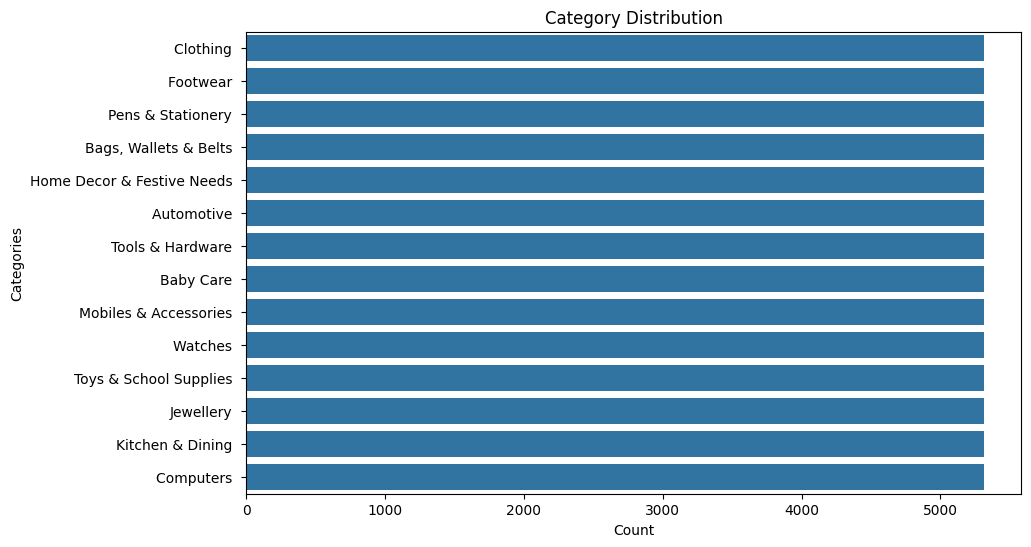

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(y="product_category_tree", data=df_resampled, order=df_resampled['product_category_tree'].value_counts().index)
plt.title('Category Distribution')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.savefig(os.path.join(image_folder, "resampled_prod_category_distribution.png"))
plt.show()

In [34]:
# add a new colm for the length of the reveiws :

df_resampled['length'] = df_resampled['description'].apply(lambda x : len(x.split(' ')))

In [35]:
df_resampled.head(3)

description product_category_tree  \
0  Key Features of Alisha Solid Women's Cycling S...             Clothing    
1  Key Features of AW Bellies Sandals Wedges Heel...             Footwear    
2  Key Features of Alisha Solid Women's Cycling S...             Clothing    

   length  
0      64  
1     107  
2      63

In [36]:
# chacking the name of the different category :

df_resampled['product_category_tree'].unique()

array(['Clothing ', 'Footwear ', 'Pens & Stationery ',
       'Bags, Wallets & Belts ', 'Home Decor & Festive Needs ',
       'Automotive ', 'Tools & Hardware ', 'Baby Care ',
       'Mobiles & Accessories ', 'Watches ', 'Toys & School Supplies ',
       'Jewellery ', 'Kitchen & Dining ', 'Computers '], dtype=object)

In [37]:
# creating a dataframe  to store the mean length of ecah category

results=[]
for x in df_resampled['product_category_tree'].unique():
    mean_length = round(df_resampled[df_resampled['product_category_tree'] == x]['length'].mean())
    results.append({'category': x, 'MeanLength': mean_length})

mean_length_df = pd.DataFrame(results)

In [38]:
mean_length_df

category  MeanLength
0                     Clothing           64
1                     Footwear           55
2            Pens & Stationery           56
3        Bags, Wallets & Belts           85
4   Home Decor & Festive Needs          102
5                   Automotive           82
6             Tools & Hardware           56
7                    Baby Care           76
8        Mobiles & Accessories          124
9                      Watches           58
10      Toys & School Supplies           48
11                   Jewellery           51
12            Kitchen & Dining          111
13                   Computers           91

#### Plotting the mean Length for each category

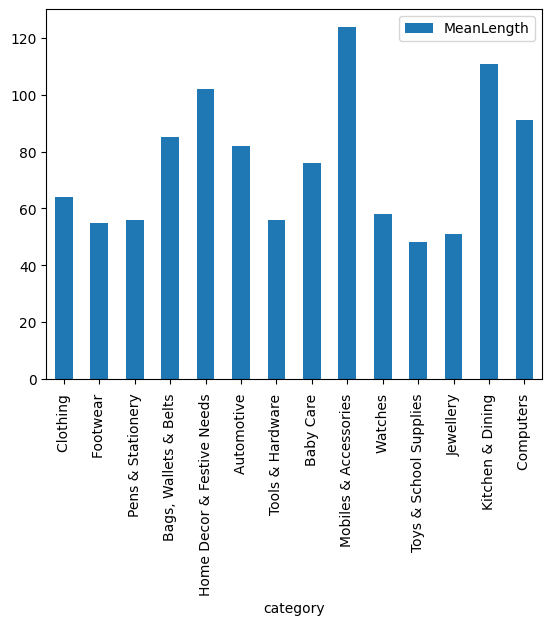

In [40]:
mean_length_df.plot(kind = 'bar', x = 'category', y ='MeanLength')

# save the figue
plt.savefig(os.path.join(image_folder, "Mean Length of Description by Category.png"))
plt.show()

*  we can see that the mean description lenghts for most categories are in the range of 40-120

#### Plotting the distribution based on the length of the description for each category

In [43]:
df_resampled['length'] = df_resampled['product_category_tree'].str.len()

In [44]:
xy = len(df_resampled[df_resampled['product_category_tree']=='Clothing'])
xy

0

In [45]:
# getting the stopwords of the english Language and storing it as a set

stopwords = set(stopwords.words('english'))
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [46]:
# Removing stopwords from the descriptions and starting the cleaned description in a different colm :

df_resampled['clean_description'] = df_resampled['description'].apply(lambda x : " ".join([word for word in x.split() if word not in (stopwords)]))

In [47]:
# defining a func for content cleaning :

def text_clean(content):
    # lowercase the content
    content = content.lower()
    # remove puctuation 
    content = re.sub('[()!?]', " ", content)
    content = re.sub('\[.*?\]', " ", content)
    # remove non alpha numeric occurance
    content = re.sub('[^a-z0-9]', " ", content)
    # remove the @ mention
    content = re.sub('@[A-Za-z0-9_]+', "", content)
    # remive the hashtag
    content = re.sub('#[A-Za-z0-9_]+', "", content)
    # remove any links
    content = re.sub(r"http\s+", "",content)
    content = re.sub(r"www.\s+", "",content)
    return content

In [48]:
# apply the text_clean function on the clean description colm :

df_resampled['clean_description'] = df_resampled['clean_description'].apply(text_clean)

In [49]:
# dropping the length colm :

df_resampled = df_resampled.drop('length', axis =1)

In [50]:
# add back the length of cleanned description after the cleaned description colm :

df_resampled['length'] = df_resampled['clean_description'].apply(lambda x: len(x.split(' ')))

In [51]:
df_resampled.head(3)

description product_category_tree  \
0  Key Features of Alisha Solid Women's Cycling S...             Clothing    
1  Key Features of AW Bellies Sandals Wedges Heel...             Footwear    
2  Key Features of Alisha Solid Women's Cycling S...             Clothing    

                                   clean_description  length  
0  key features alisha solid women s cycling shor...      66  
1  key features aw bellies sandals wedges heel ca...      99  
2  key features alisha solid women s cycling shor...      63

In [52]:
# removing the stopwords agian becz of new words created after pplying the next_clean function :

df_resampled['clean_description'] = df_resampled['clean_description'].apply(lambda x : " ".join([word for word in x.split() if word not in (stopwords)]))

In [53]:
# apply the text_clean func again on the clean_description colm :

df_resampled['clean_description'] = df_resampled['clean_description'].apply(text_clean)

In [54]:
# update the length of the description :

df_resampled['length'] = df_resampled['clean_description'].apply(lambda x: len(x.split(' ')))

In [55]:
df_resampled.sample()

description  \
3596  Buy Shoppingtara Elephant Pair Gift Showpiece ...   

            product_category_tree  \
3596  Home Decor & Festive Needs    

                                      clean_description  length  
3596  buy shoppingtara elephant pair gift showpiece ...      30

In [56]:
# function to remove duplicated words while prserving order

def remove_duplicated_words(text):
    words = text.split() # split text into word
    unique_words = list(OrderedDict.fromkeys(words))  # use orderdict to maintain order
    return ' '.join(unique_words) # join thelist back into a string

In [57]:
# apply the fun to the cleaned product description :

df_resampled['clean_description'] = df_resampled['clean_description'].apply(remove_duplicated_words)

In [58]:
# update the length of the descriptions after removing duplicate words :

df_resampled['length'] = df_resampled['clean_description'].apply(lambda x: len(x.split(' ')))

In [59]:
# after removing duplicate words :

df_resampled.head()

description product_category_tree  \
0  Key Features of Alisha Solid Women's Cycling S...             Clothing    
1  Key Features of AW Bellies Sandals Wedges Heel...             Footwear    
2  Key Features of Alisha Solid Women's Cycling S...             Clothing    
3  Key Features of Alisha Solid Women's Cycling S...             Clothing    
4  Key Features of dilli bazaaar Bellies, Corpora...             Footwear    

                                   clean_description  length  
0  key features alisha solid women cycling shorts...      38  
1  key features aw bellies sandals wedges heel ca...      70  
2  key features alisha solid women cycling shorts...      37  
3  key features alisha solid women cycling shorts...      38  
4  key features dilli bazaaar bellies corporate c...      37

In [60]:
# Saving the feature Engineered dataset :

file_path = os.path.join(r"C:\Users\komal\Downloads\HACKATHON\Hackathon ANS\Hackathon data", "featured_engineered_data.csv")
df_resampled.to_csv(file_path, index = False)

In [61]:
# creating a dataframe  to store the mean length of ecah category

results=[]
for x in df_resampled['product_category_tree'].unique():
    mean_length = round(df_resampled[df_resampled['product_category_tree'] == x]['length'].mean())
    results.append({'category': x, 'MeanLength': mean_length})

mean_length_df = pd.DataFrame(results)

In [62]:
mean_length_df

category  MeanLength
0                     Clothing           28
1                     Footwear           28
2            Pens & Stationery           33
3        Bags, Wallets & Belts           46
4   Home Decor & Festive Needs           40
5                   Automotive           40
6             Tools & Hardware           27
7                    Baby Care           39
8        Mobiles & Accessories           44
9                      Watches           32
10      Toys & School Supplies           29
11                   Jewellery           26
12            Kitchen & Dining           39
13                   Computers           39

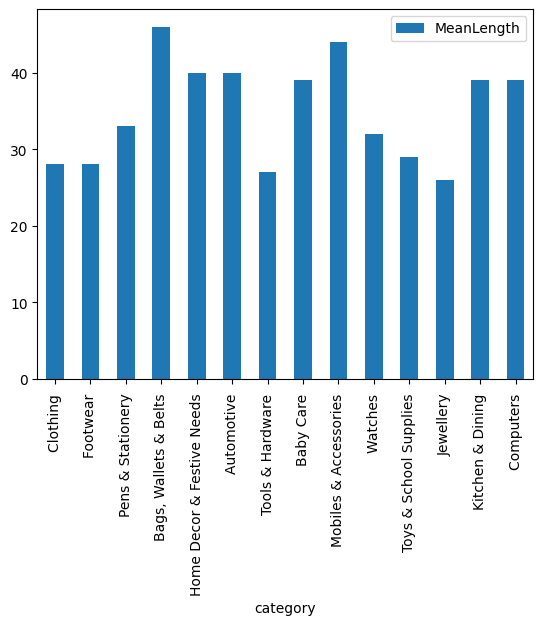

In [63]:
mean_length_df.plot(kind = 'bar', x = 'category', y ='MeanLength')

# save the figue
plt.savefig(os.path.join(image_folder, "Final Mean Length of Description by Category.png"))
plt.show()

* After cleanning the mean lengths of product descriptions have reduced to a great extent and are now in a range of 30-40 compared to 40-120

In [65]:
df_resampled.head(2)

description product_category_tree  \
0  Key Features of Alisha Solid Women's Cycling S...             Clothing    
1  Key Features of AW Bellies Sandals Wedges Heel...             Footwear    

                                   clean_description  length  
0  key features alisha solid women cycling shorts...      38  
1  key features aw bellies sandals wedges heel ca...      70

In [66]:
df_resampled['product_category_tree'].shape

(74424,)

# Train Test Split

In [68]:
x = df_resampled['clean_description'] # feature data
y = df_resampled['product_category_tree'] # target data

In [69]:
# split the data using 'train-test-split' method :

x_train, x_test, y_train, y_test =train_test_split(x,y, test_size = 0.2, stratify= y) 

In [70]:
print('x_treain shape =', x_train.shape) # shape of x_train
print('x_test shape =', x_test.shape)   # shape of x_test

x_treain shape = (59539,)
x_test shape = (14885,)


In [71]:
# check 'class imbalanced' for target data :

y_train.value_counts()

product_category_tree
Automotive                     4253
Watches                        4253
Kitchen & Dining               4253
Jewellery                      4253
Clothing                       4253
Bags, Wallets & Belts          4253
Computers                      4253
Footwear                       4253
Tools & Hardware               4253
Toys & School Supplies         4253
Mobiles & Accessories          4253
Home Decor & Festive Needs     4252
Baby Care                      4252
Pens & Stationery              4252
Name: count, dtype: int64

There is no class such imbalanced, for target data.

In [73]:
# check 'class imbalanced' for target data :

y_test.value_counts()

product_category_tree
Home Decor & Festive Needs     1064
Baby Care                      1064
Pens & Stationery              1064
Kitchen & Dining               1063
Tools & Hardware               1063
Watches                        1063
Mobiles & Accessories          1063
Footwear                       1063
Bags, Wallets & Belts          1063
Automotive                     1063
Toys & School Supplies         1063
Clothing                       1063
Computers                      1063
Jewellery                      1063
Name: count, dtype: int64

There is no class such imbalanced, for target data.

### Performing wordembading using Word2Vec

In [76]:
# Tokenize the descriptions :

train_sentences = [word_tokenize(description.lower()) for description in x_train]
test_sentences = [word_tokenize(description.lower()) for description in x_test]

In [77]:
train_sentences

[['buy',
  'allure',
  'auto',
  'cm',
  '409',
  'car',
  'mat',
  'tata',
  'zest',
  'rs',
  '920',
  'online',
  'best',
  'prices',
  'free',
  'shipping',
  'cash',
  'delivery',
  'genuine',
  'products',
  '30',
  'day',
  'replacement',
  'guarantee'],
 ['buy',
  'exotic',
  'india',
  'lord',
  'ganesha',
  'carved',
  'hematite',
  'showpiece',
  '5',
  '08',
  'cm',
  'rs',
  '2750',
  'online',
  'best',
  'prices',
  'free',
  'shipping',
  'cash',
  'delivery',
  'genuine',
  'products',
  '30',
  'day',
  'replacement',
  'guarantee'],
 ['diviniti',
  'dg',
  'royal',
  'ornamental',
  'size',
  '2',
  '5',
  'murgan',
  'religious',
  'wall',
  'hanging',
  'showpiece',
  '28',
  'cm',
  'glass',
  'gold',
  'price',
  'rs',
  '140',
  'house',
  'bring',
  'double',
  'royale',
  'frames',
  'perfect',
  'accessories',
  'desk',
  'etc',
  'set',
  'embodied',
  'swiss',
  'technology',
  '24',
  'carat',
  'plated',
  'foil',
  'definite',
  'buy',
  'personal',
  'u

In [78]:
test_sentences

[['prithish',
  'move',
  'tree',
  'ceramic',
  'mug',
  '330',
  'ml',
  'price',
  'rs',
  '175',
  'get',
  'talking',
  'coffee',
  'wide',
  'selection',
  'cute',
  'catchy',
  'designs',
  'means',
  'sure',
  'find',
  'quote',
  'says',
  'way',
  'mugs',
  'bring',
  'smiles',
  'forget',
  'share',
  'like',
  'make',
  'great',
  'gifts',
  'beautifully',
  'designed',
  'quality',
  'ink',
  'attractive',
  'graphics',
  'perfect',
  'around',
  'enjoyment',
  'express',
  'distinctive',
  'give',
  'freedom',
  'broadcast',
  'special',
  'message',
  'holiday',
  'cheer',
  'love',
  'cupcakes',
  'affordable',
  'also',
  'gifting',
  'show',
  'others',
  'well',
  'know',
  'break',
  'laughs',
  'happy',
  'sipping'],
 ['buy',
  'destudio',
  'large',
  'wall',
  'sticker',
  'rs',
  '699',
  'online',
  'best',
  'prices',
  'free',
  'shipping',
  'cash',
  'delivery',
  'genuine',
  'products',
  '30',
  'day',
  'replacement',
  'guarantee'],
 ['super',
  'drool

In [79]:
# initialize and train Word2Vec model :

word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4, sg =1) # sg=1 for skip_gram model

In [80]:
# func to compute the avg Word2Vec vector for a given description :

def get_average_word2vec(sentence, model, vector_size):
    words = [word for word in sentence if word in model.wv.key_to_index]
    if len(words) ==0 :
        return np.zeros(vector_size)
    return np.mean([model.wv[word] for word in words], axis = 0)

# Apply the function to each tokenized sentance in the lists :

train_vectors = [get_average_word2vec(sentence, word2vec_model, vector_size=100) for sentence in train_sentences]
test_vectors = [get_average_word2vec(sentence, word2vec_model, vector_size=100) for sentence in test_sentences]

## Model Training and Evaluation using various model

##### Creating a score card and defining a function to update it with important performance metrics

In [83]:
# Creating an empty dataframe to store the scores for various algorithm

score_card = pd.DataFrame(columns=['model_name', 'Accuracy Score', 'Precision Score','Recall Score','F1 Score'])

# append the result table for all performance score

def update_score_card(y_test, y_pred, model_name):
    global score_card  # assign as global variable

    score_card = pd.concat([score_card, pd.DataFrame([{'model_name':model_name,
                                                       'Accuracy Score': accuracy_score(y_test, y_pred),
                                                      'Precision Score': precision_score(y_test, y_pred, average= 'weighted'),
                                                      'Recall Score':recall_score(y_test, y_pred, average = 'weighted'),
                                                      'F1 Score': f1_score(y_test,y_pred, average = 'weighted')}])],
                          ignore_index = True) 

In [84]:
# convert to numpy array :

x_train_vectors = np.array(train_vectors)
x_test_vectors = np.array(test_vectors)

In [85]:
x_test_vectors

array([[-0.16934557,  0.00671218, -0.12934287, ..., -0.5343379 ,
         0.43298256,  0.01452663],
       [-0.26506063,  0.33956528, -0.07548271, ...,  0.00920099,
         0.09667973, -0.08703304],
       [-0.21299347,  0.30585423,  0.16063598, ..., -0.21447632,
        -0.11624672, -0.32085887],
       ...,
       [ 0.12809913,  0.01570903,  0.11835936, ...,  0.12585673,
        -0.01515331, -0.06856404],
       [ 0.21231185,  0.02137301,  0.09103956, ..., -0.09354275,
         0.00642626,  0.0791953 ],
       [-0.25502023,  0.2706434 , -0.04319351, ..., -0.07470752,
         0.16945808, -0.25033846]], dtype=float32)

In [86]:
x_train_vectors

array([[-0.30692747,  0.35526356, -0.07624575, ...,  0.04345443,
         0.11923493,  0.02788684],
       [-0.34125382,  0.23820247, -0.15813962, ...,  0.13755712,
         0.1349517 ,  0.05570672],
       [-0.00702974,  0.01398716,  0.0268355 , ..., -0.13088681,
         0.00592256,  0.1116343 ],
       ...,
       [-0.21466362,  0.20862953, -0.07954118, ...,  0.03129216,
         0.00107302, -0.04453513],
       [-0.07319109,  0.16792229, -0.01682117, ..., -0.12617718,
         0.05439524,  0.2926745 ],
       [-0.36453828,  0.2812005 , -0.07729115, ..., -0.25740284,
         0.13941516, -0.1109515 ]], dtype=float32)

# 1) Random Forest Classifier

In [88]:
# Train RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_vectors, y_train)

# Test
y_pred_rf = rf_classifier.predict(x_test_vectors)

In [89]:
# Accuracy :

accuracy_score(y_test, y_pred_rf)

0.9986563654685925

In [90]:
# Classification Report & F1 Score:

print(classification_report(y_test, y_pred_rf))

                             precision    recall  f1-score   support

                Automotive        1.00      1.00      1.00      1063
                 Baby Care        1.00      1.00      1.00      1064
     Bags, Wallets & Belts        1.00      1.00      1.00      1063
                  Clothing        1.00      1.00      1.00      1063
                 Computers        1.00      1.00      1.00      1063
                  Footwear        1.00      1.00      1.00      1063
Home Decor & Festive Needs        1.00      1.00      1.00      1064
                 Jewellery        1.00      1.00      1.00      1063
          Kitchen & Dining        1.00      1.00      1.00      1063
     Mobiles & Accessories        1.00      1.00      1.00      1063
         Pens & Stationery        0.99      0.99      0.99      1064
          Tools & Hardware        1.00      1.00      1.00      1063
    Toys & School Supplies        0.99      0.99      0.99      1063
                   Watches       

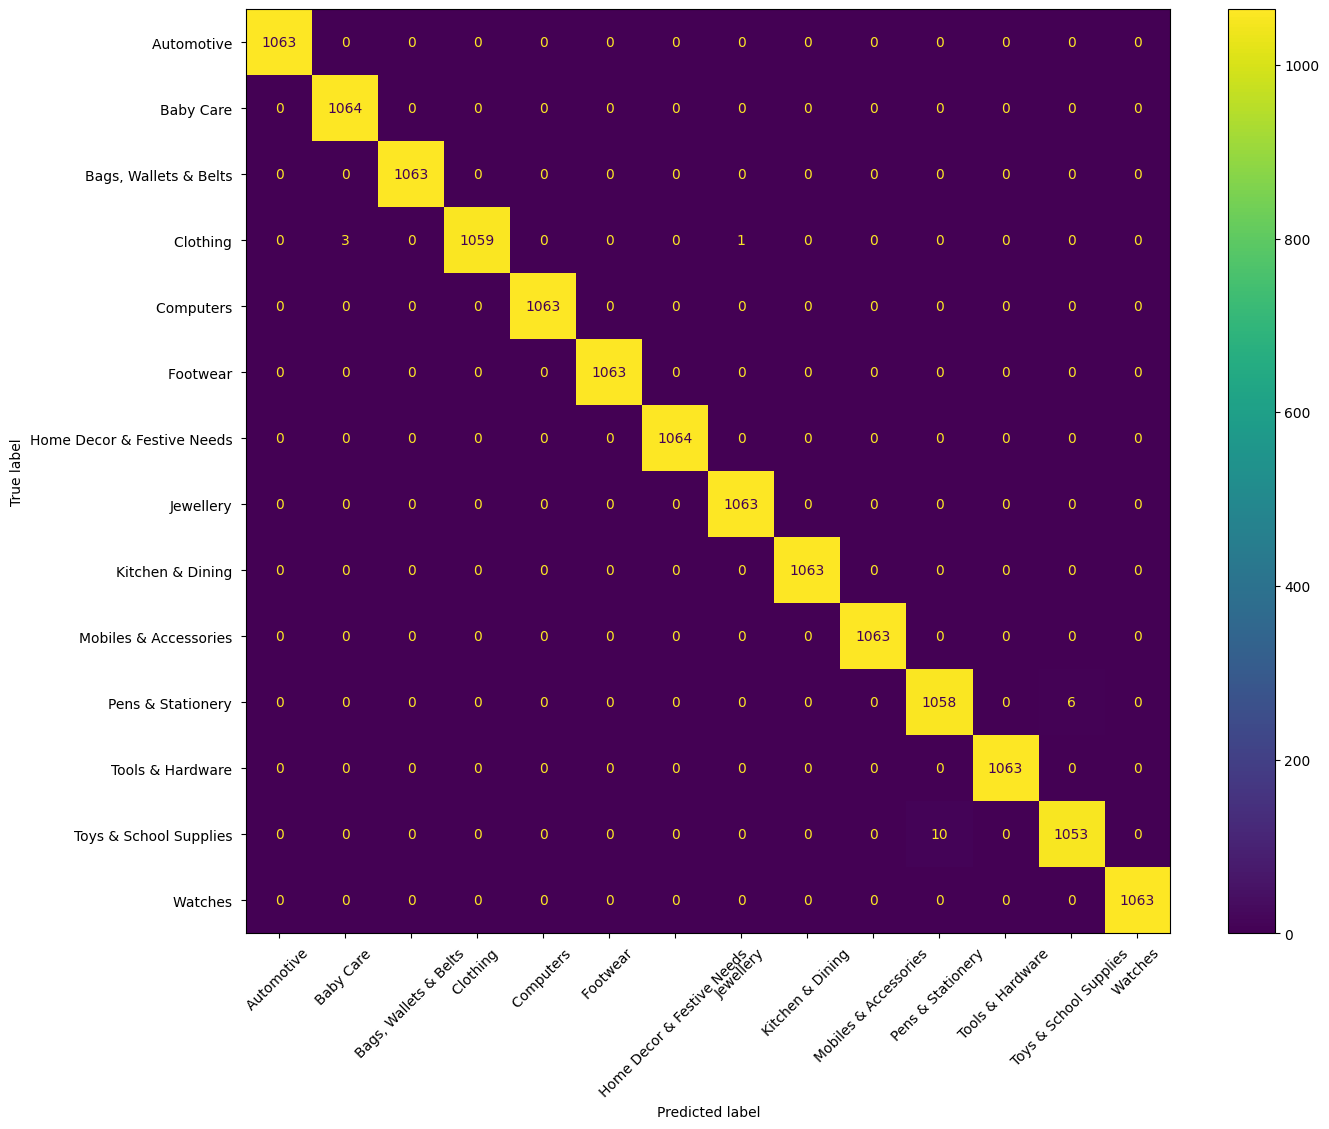

In [91]:
# Confusion Matrix :

cmlr = confusion_matrix(y_test, y_pred_rf, labels = rf_classifier.classes_)

# confusion Matrix display instanced
disp = ConfusionMatrixDisplay(confusion_matrix=cmlr, display_labels=rf_classifier.classes_)

# plot the confusionMatrix
plt.figure(figsize=(15,12))
ax = disp.plot(values_format ='d', ax = plt.gca())
plt.xticks(rotation = 45)

# save figure
plt.savefig(os.path.join(image_folder, "rf_confusion_matrix.png"))
plt.show()

In [92]:
# cheking predicted labels :

y_pred_rf

array(['Kitchen & Dining ', 'Home Decor & Festive Needs ',
       'Tools & Hardware ', ..., 'Bags, Wallets & Belts ',
       'Kitchen & Dining ', 'Toys & School Supplies '], dtype=object)

In [93]:
# chking training accuracy by filtering on the train data :

y_predt = rf_classifier.predict(x_train_vectors)

accuracy = accuracy_score(y_train, y_predt)
print('Accuracy score :', accuracy)

Accuracy score : 0.9989250743210333


In [94]:
# Cross validation score :

scores = cross_val_score(rf_classifier, x_train_vectors, y_train, cv= 5, scoring='accuracy')
scores

array([0.99806853, 0.99857239, 0.99848841, 0.99899227, 0.99832032])

Interpretation

the model is already achieve 100% accuracy and 100 on F1 score, so no need to perform Hyperparameter tuning for this model

In [97]:
# calling the update score card method to update the score with this model
update_score_card(y_test, y_pred_rf, 'RFC_model')

## checking accuracy on Test_result Data

In [99]:
# Load the dataset :

ugt = pd.read_csv('test_data1.csv')  
ugt.head(2)

uniq_id            crawl_timestamp  \
0  4fb99d98225f415e7ece96938e95628f  2015-12-20 08:26:17 +0000   
1  4ea284c8d38b2ea97a1c2a26f34e057c  2015-12-20 08:26:17 +0000   

                                         product_url  \
0  http://www.flipkart.com/v-v-art-brass-bracelet...   
1  http://www.flipkart.com/kalpaveda-copper-cuff/...   

                   product_name               pid  retail_price  \
0        V&V ART Brass Bracelet  BBAE6NYHCDTEZJTB         470.0   
1  Kalpaveda Copper Copper Cuff  BBAEDFFKZJTY7SZZ        1200.0   

   discounted_price                                              image  \
0             423.0  ["http://img6a.flixcart.com/image/bangle-brace...   
1            1200.0  ["http://img6a.flixcart.com/image/bangle-brace...   

   is_FK_Advantage_product                                        description  \
0                    False  V&V ART Brass Bracelet - Buy V&V ART Brass Bra...   
1                    False  Kalpaveda Copper Copper Cuff\n                ...   

        product_rating       overall_rating      brand  \
0  No rating available  No rating available    V&V ART   
1  No rating available  No rating available  Kalpaveda   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Stretchabl...

In [100]:
# store the necessary data :

ugt = ugt[['description']]

In [101]:
ugt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  2534 non-null   object
dtypes: object(1)
memory usage: 19.9+ KB


In [102]:
ugt.isna().sum()/len(df)*100

# there is no misssing values in upgrad's data

description    0.0
dtype: float64

In [103]:
# add a new colm for the length of the reveiws :

ugt['length'] = ugt['description'].apply(lambda x : len(x.split(' ')))

In [104]:
ugt.head(3)

description  length
0  V&V ART Brass Bracelet - Buy V&V ART Brass Bra...      28
1  Kalpaveda Copper Copper Cuff\n                ...     259
2  Thelostpuppy Book Cover for Apple iPad Air (Mu...     121

In [105]:
# Removing stopwords from the descriptions and starting the cleaned description in a different colm :

ugt['clean_description'] = ugt['description'].apply(lambda x : " ".join([word for word in x.split() if word not in (stopwords)]))

In [106]:
# apply the func on the clean description colm :

ugt['clean_description'] = ugt['clean_description'].apply(text_clean)

In [107]:
# dropping the length colm:

ugt = ugt.drop('length', axis =1)

In [108]:
# add a new colm for the length of the reveiws :

ugt['length'] = ugt['clean_description'].apply(lambda x : len(x.split(' ')))

In [109]:
ugt.head(3)

description  \
0  V&V ART Brass Bracelet - Buy V&V ART Brass Bra...   
1  Kalpaveda Copper Copper Cuff\n                ...   
2  Thelostpuppy Book Cover for Apple iPad Air (Mu...   

                                   clean_description  length  
0  v v art brass bracelet   buy v v art brass bra...      35  
1  kalpaveda copper copper cuff price  rs  1 200 ...     282  
2  thelostpuppy book cover apple ipad air  multic...      84

In [110]:
# Removing stopwords again bcz of new words created after applying the text_clean func :

ugt['clean_description'] = ugt['clean_description'].apply(lambda x : " ".join([word for word in x.split() if word not in (stopwords)]))

In [111]:
# apply the text_clean func again on the clean_description colm :

ugt['clean_description'] = ugt['clean_description'].apply(text_clean)

In [112]:
# update  the length of the description :

ugt['length'] = ugt['clean_description'].apply(lambda x : len(x.split(' ')))

In [113]:
ugt.head(3)

description  \
0  V&V ART Brass Bracelet - Buy V&V ART Brass Bra...   
1  Kalpaveda Copper Copper Cuff\n                ...   
2  Thelostpuppy Book Cover for Apple iPad Air (Mu...   

                                   clean_description  length  
0  v v art brass bracelet buy v v art brass brace...      25  
1  kalpaveda copper copper cuff price rs 1 200 1 ...     158  
2  thelostpuppy book cover apple ipad air multico...      64

In [114]:
# Apply the func to the cleand product descriptions :

ugt['clean_description']= ugt['clean_description'].apply(remove_duplicated_words)

In [115]:
# update the length of the description after removng duplicate words :

ugt['length'] = ugt['clean_description'].apply(lambda x : len(x.split(' ')))

In [116]:
ugt = ugt[['clean_description']]

In [117]:
ugt.head(3)

clean_description
0  v art brass bracelet buy rs 423 flipkart com g...
1  kalpaveda copper cuff price rs 1 200 attract e...
2  thelostpuppy book cover apple ipad air multico...

In [118]:
ugt_sentences = [word_tokenize(description.lower()) for description in ugt['clean_description']]

In [119]:
 ugt_sentences

[['v',
  'art',
  'brass',
  'bracelet',
  'buy',
  'rs',
  '423',
  'flipkart',
  'com',
  'genuine',
  'products',
  '30',
  'day',
  'replacement',
  'guarantee',
  'free',
  'shipping',
  'cash',
  'delivery'],
 ['kalpaveda',
  'copper',
  'cuff',
  'price',
  'rs',
  '1',
  '200',
  'attract',
  'emit',
  'divine',
  'consciousness',
  'wearing',
  'bracelets',
  'cuffs',
  'known',
  'antioxidant',
  'properties',
  'help',
  'reduce',
  'joint',
  'pain',
  'gain',
  'freedom',
  'movement',
  'throughout',
  'body',
  '2',
  'products',
  'verified',
  '97',
  'pure',
  'intertek',
  '3',
  'soft',
  'metal',
  'therefore',
  'use',
  'brass',
  'inserts',
  'ensure',
  'retain',
  'shape',
  'last',
  'long',
  '4',
  'ayurveda',
  'recommends',
  'jewellery',
  'benefit',
  'multiple',
  'benefits',
  'mentioned',
  'health',
  'recommended',
  '5',
  'doctor',
  '6',
  'rub',
  'product',
  'lemon',
  'covered',
  'salt',
  '7',
  'gently',
  'wash',
  'wipe',
  'cloth',
  '

In [120]:
# Train a Word2vec model on your tokenized sentences

word2vec_model2 = Word2Vec(sentences= ugt_sentences, vector_size=100, window=5, min_count=1, workers=4, sg =1)

In [121]:
word2vec_model2

In [122]:
ugt_vectors = [get_average_word2vec(sentence, word2vec_model2, vector_size=100) for sentence in ugt_sentences]

In [123]:
ugt_vectors

[array([-0.18226136,  0.46052963, -0.11917511, -0.06465068,  0.3785224 ,
        -0.08749839,  0.37805855,  0.34899664,  0.45988044,  0.10457467,
        -0.18439409, -0.5538959 ,  0.33359852,  0.355058  , -0.1729168 ,
        -0.42187104,  0.1668963 , -0.7976421 , -0.333772  , -0.5819374 ,
         0.37597734, -0.33935   , -0.17244674,  0.06170316, -0.15217966,
         0.47472456,  0.04346911, -0.26310977, -0.44612694, -0.31689745,
         0.2636841 ,  0.09304791, -0.09341516, -0.20408404, -0.23586504,
         0.01761838,  0.4137904 , -0.3152619 ,  0.05438556,  0.02891535,
        -0.86548436, -0.24853864,  0.12269774, -0.66432154,  0.05845536,
        -0.18308876, -0.28259066,  0.09323309,  0.7837185 ,  0.9292123 ,
        -0.07447692, -0.0775054 , -0.03950668,  0.5113143 , -0.09866862,
         0.62225956,  0.15420818,  0.49955705, -0.67840075, -0.62804025,
         0.48287398, -0.31950617, -0.26984963, -0.17124203, -0.47381768,
         0.03710852, -0.10689273,  0.00787055, -0.1

In [124]:
ugt_npyarray = np.array(ugt_vectors)

In [125]:
ugt_npyarray

array([[-1.8226136e-01,  4.6052963e-01, -1.1917511e-01, ...,
        -4.3299615e-01, -5.2062356e-01,  4.4337675e-01],
       [-8.2695909e-02,  2.1984968e-01, -1.0094245e-02, ...,
        -1.6891615e-01, -5.1789661e-04,  9.0450495e-02],
       [-6.8784714e-02,  6.9922763e-01, -3.7226804e-02, ...,
        -4.0089476e-01,  8.2201034e-02,  1.4457352e-01],
       ...,
       [-2.4118562e-01,  4.3742195e-01, -1.0241979e-01, ...,
        -4.2769369e-01, -6.1620283e-01,  5.1427084e-01],
       [-2.4551076e-01,  4.3628001e-01, -1.0310420e-01, ...,
        -4.3264535e-01, -6.1345381e-01,  5.0828004e-01],
       [-2.4118562e-01,  4.3742195e-01, -1.0241979e-01, ...,
        -4.2769369e-01, -6.1620283e-01,  5.1427084e-01]], dtype=float32)

In [126]:
# Make prediction using ugt_npyarray
ugtpreddrf = rf_classifier.predict(ugt_npyarray)

In [127]:
ugtpreddrf.shape

(2534,)

In [128]:
ugtpreddrf

array(['Clothing ', 'Home Decor & Festive Needs ',
       'Home Decor & Festive Needs ', ..., 'Clothing ', 'Clothing ',
       'Clothing '], dtype=object)

In [129]:
# loading test_result data 
ugt_res = pd.read_csv('test_results.csv')
ugt_res.head()

product_category_tree
0              Jewellery 
1              Jewellery 
2  Mobiles & Accessories 
3              Jewellery 
4              Jewellery

In [130]:
ugt_resarr = ugt_res.values.ravel()

In [131]:
ugt_resarr.shape

(2534,)

In [132]:
ugt_resarr

array(['Jewellery ', 'Jewellery ', 'Mobiles & Accessories ', ...,
       'Baby Care ', 'Baby Care ', 'Baby Care '], dtype=object)

In [133]:
# Accuracy :
accuracy_score(ugt_resarr, ugtpreddrf) # y_test should be the labels from the train-test split

0.05090765588003157

In [134]:
# Classification Report & F1 Score:

print('Classifiaction Report : \n', classification_report(ugt_resarr, ugtpreddrf))

Classifiaction Report : 
                              precision    recall  f1-score   support

                Automotive        0.00      0.00      0.00        75
                 Baby Care        0.00      0.00      0.00       259
     Bags, Wallets & Belts        0.00      0.00      0.00       107
                  Clothing        0.01      0.00      0.01       882
                 Computers        0.00      0.00      0.00        47
                  Footwear        0.00      0.00      0.00       144
Home Decor & Festive Needs        0.13      0.57      0.21       215
                 Jewellery        0.01      0.01      0.01       313
          Kitchen & Dining        0.00      0.00      0.00        37
     Mobiles & Accessories        0.00      0.00      0.00       331
         Pens & Stationery        0.00      0.00      0.00        49
          Tools & Hardware        0.00      0.00      0.00        12
    Toys & School Supplies        0.00      0.00      0.00        59
       

* This model is prforming poorly on test_result data .
***
***

# 2) Logistic Regression Model

In [137]:
lr = LogisticRegression(class_weight='balanced')
# fit 
lr.fit(x_train_vectors,y_train)
y_pred_lr = lr.predict(x_test_vectors)

Accuracy := 

In [139]:
accuracy_score(y_test, y_pred_lr)

0.9588176016123614

classificaton report & F1 score :=

In [141]:
print(classification_report( y_test , y_pred_lr))

                             precision    recall  f1-score   support

                Automotive        0.98      0.99      0.98      1063
                 Baby Care        0.94      0.95      0.95      1064
     Bags, Wallets & Belts        0.98      0.98      0.98      1063
                  Clothing        0.97      0.96      0.96      1063
                 Computers        0.95      0.97      0.96      1063
                  Footwear        1.00      0.99      1.00      1063
Home Decor & Festive Needs        0.94      0.97      0.95      1064
                 Jewellery        1.00      0.99      0.99      1063
          Kitchen & Dining        0.97      0.97      0.97      1063
     Mobiles & Accessories        0.97      0.96      0.96      1063
         Pens & Stationery        0.88      0.81      0.85      1064
          Tools & Hardware        1.00      0.98      0.99      1063
    Toys & School Supplies        0.86      0.91      0.88      1063
                   Watches       

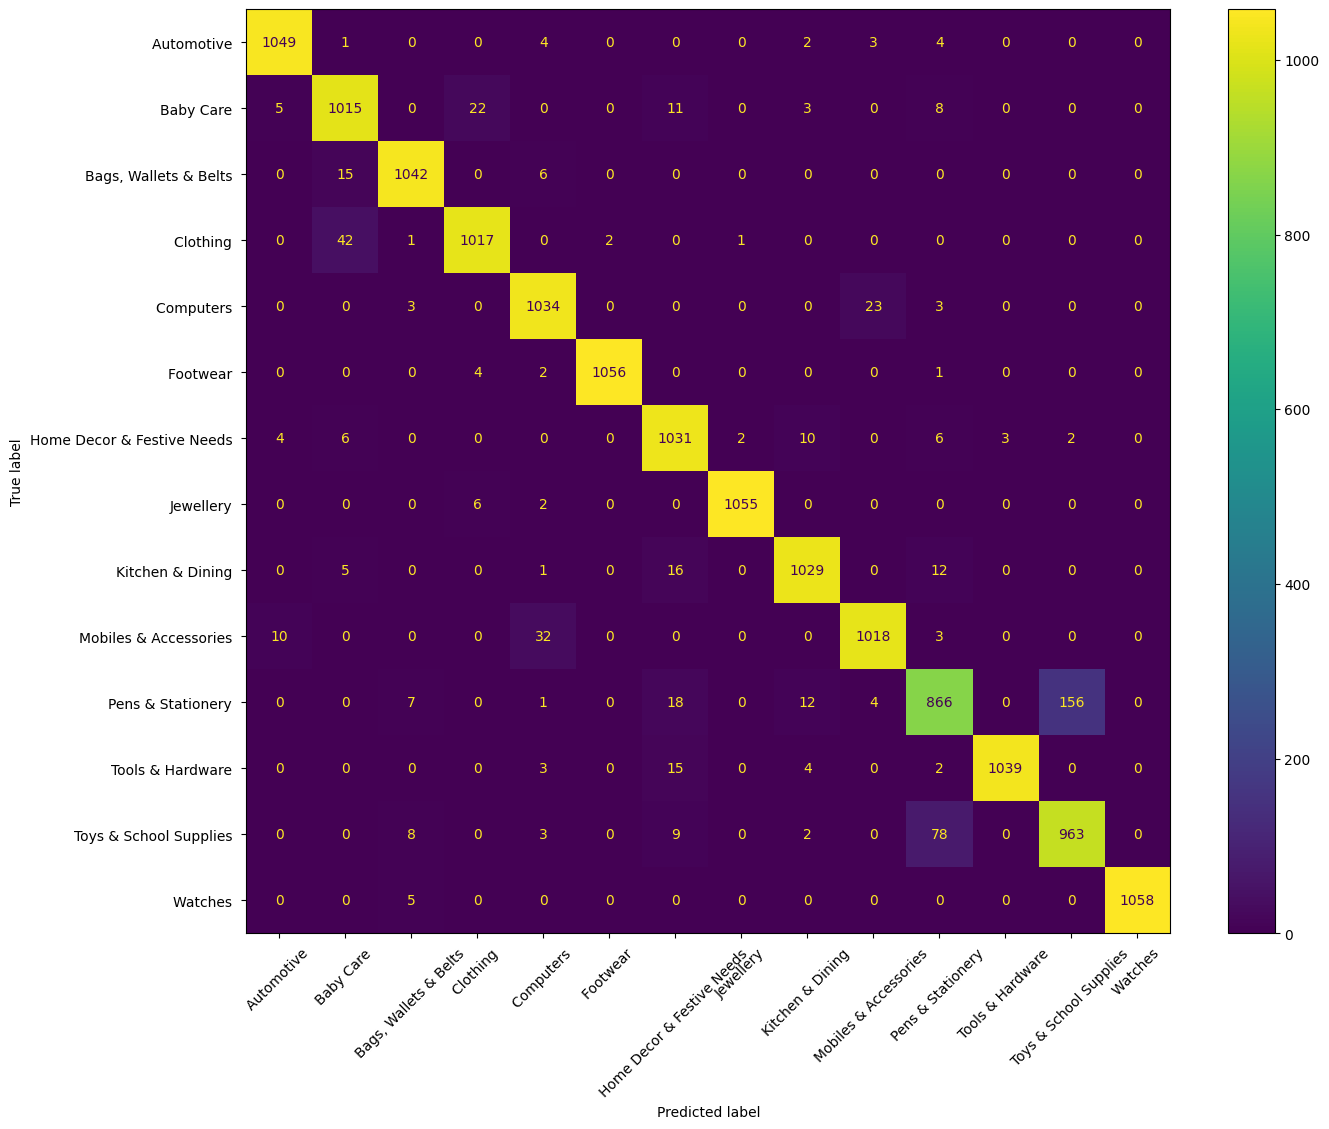

In [142]:
# Confusion Matrix :

cmblr = confusion_matrix(y_test, y_pred_lr, labels = lr.classes_)

# confusion Matrix display instanced
disp = ConfusionMatrixDisplay(confusion_matrix=cmblr, display_labels= lr.classes_)

# plot the confusionMatrix
plt.figure(figsize=(15,12))
ax = disp.plot(values_format ='d', ax = plt.gca())
plt.xticks(rotation = 45)

# save figure
plt.savefig(os.path.join(image_folder, "LR_confusion_matrix.png"))
plt.show()

In [143]:
# calling the update score card method to update the score card with model score
update_score_card(y_test, y_pred_lr, 'LR_model')

 # Hyperparameter Tuning 

In [145]:
param_grid_lr = {'C':[0.01,0.1,1,10,100],
                'solver':['liblinear','newton-cg','saga']}

grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(x_train_vectors,y_train)

best_lr = grid_search_lr.best_estimator_
print('best parameters =',grid_search_lr.best_params_)
print('best cross validation score =',grid_search_lr.best_score_)


best parameters = {'C': 100, 'solver': 'newton-cg'}
best cross validation score = 0.9784679011753248


In [146]:
best_lr

LogisticRegression(C=100, class_weight='balanced', solver='newton-cg')

In [147]:
# fit the best model on the training data
best_lr.fit(x_train_vectors, y_train)
# obtaining the prediction on the test data
y_pred_blr = best_lr.predict(x_test_vectors)

In [148]:
# accuracy =
accuracy_score(y_test, y_pred_blr)

0.9784346657709103

classificaton report & F1 score :=

In [150]:
print(classification_report( y_test, y_pred_blr))

                             precision    recall  f1-score   support

                Automotive        0.99      1.00      1.00      1063
                 Baby Care        0.98      1.00      0.99      1064
     Bags, Wallets & Belts        1.00      1.00      1.00      1063
                  Clothing        0.99      0.97      0.98      1063
                 Computers        0.99      0.99      0.99      1063
                  Footwear        1.00      1.00      1.00      1063
Home Decor & Festive Needs        0.98      0.99      0.98      1064
                 Jewellery        1.00      1.00      1.00      1063
          Kitchen & Dining        0.99      0.99      0.99      1063
     Mobiles & Accessories        0.99      0.99      0.99      1063
         Pens & Stationery        0.92      0.86      0.89      1064
          Tools & Hardware        1.00      0.99      1.00      1063
    Toys & School Supplies        0.88      0.93      0.90      1063
                   Watches       

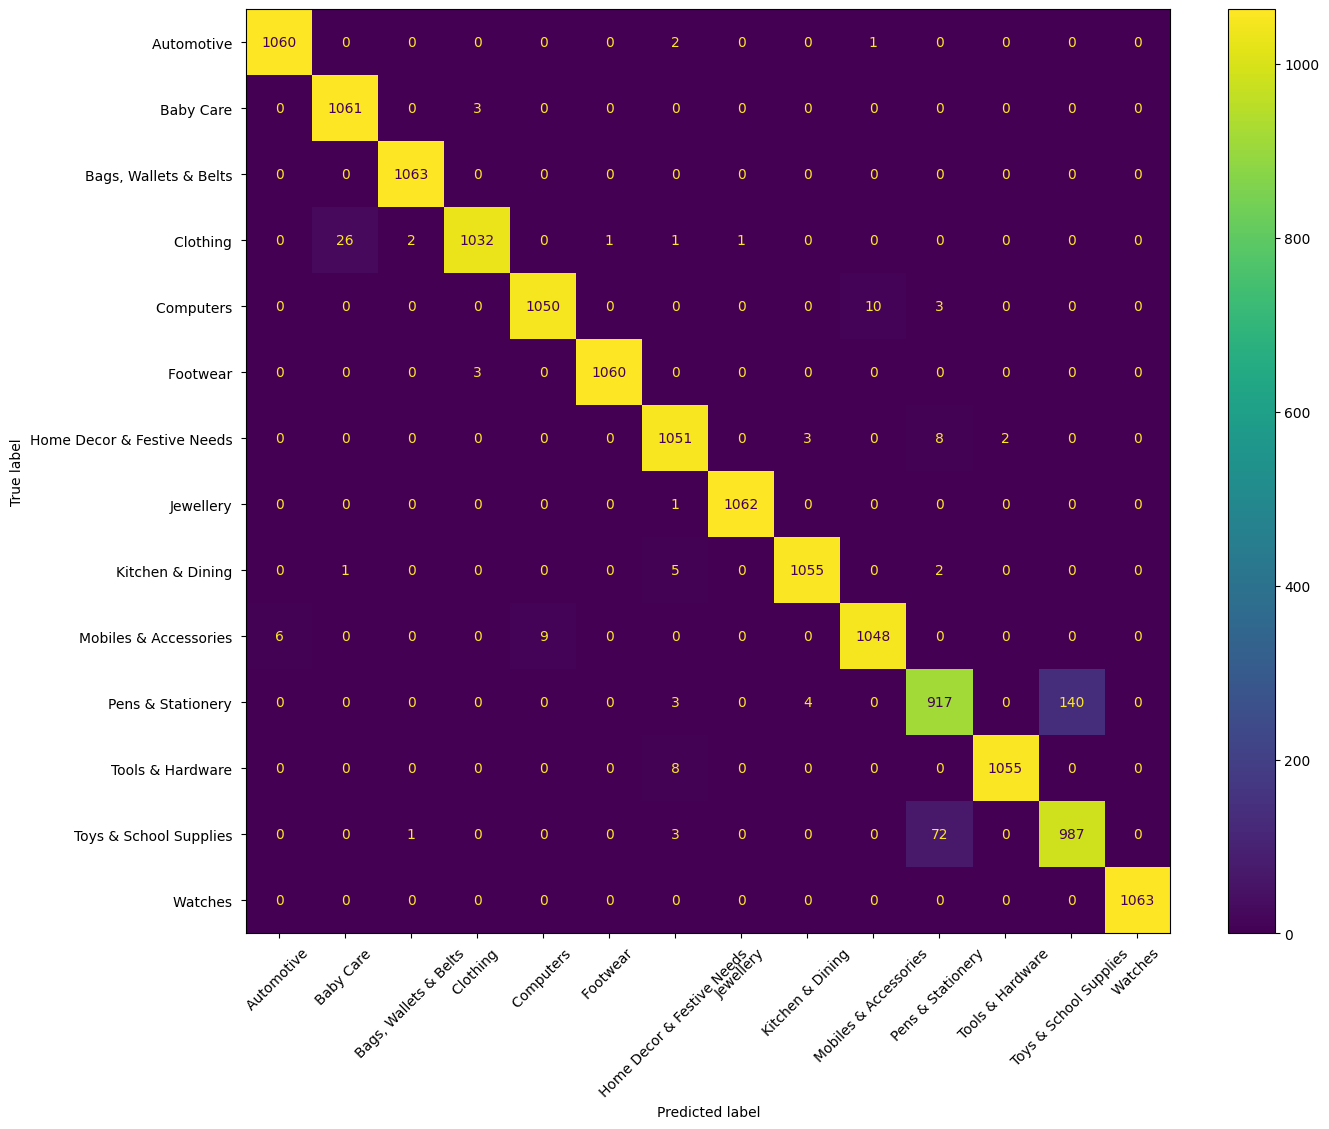

In [151]:
# Confusion Matrix :

cmblr = confusion_matrix(y_test, y_pred_blr, labels = best_lr.classes_)

# confusion Matrix display instanced
disp = ConfusionMatrixDisplay(confusion_matrix=cmblr, display_labels= best_lr.classes_)

# plot the confusionMatrix
plt.figure(figsize=(15,12))
ax = disp.plot(values_format ='d', ax = plt.gca())
plt.xticks(rotation = 45)

# save figure
plt.savefig(os.path.join(image_folder, "Tuned_LR_confusion_matrix.png"))
plt.show()

*  hyperparameter tunning is improving the accuracy slightly

In [153]:
# cross validation score

In [154]:
scores = cross_val_score(best_lr, x_train_vectors, y_train, cv=5, scoring='accuracy') # 5-fold cross validation
scores

array([0.97707424, 0.97707424, 0.97967753, 0.97967753, 0.97883598])

In [155]:
# Interpretation

In [156]:
# calling the update score card method to update the score card with model score
update_score_card(y_test, y_pred_blr, 'Best_tuned_LR_model')

# testing on upgrad data

In [158]:
# Make prediction using ugt_npyarray
ugtpredlr = best_lr.predict(ugt_npyarray)

In [159]:
ugt_resarr

array(['Jewellery ', 'Jewellery ', 'Mobiles & Accessories ', ...,
       'Baby Care ', 'Baby Care ', 'Baby Care '], dtype=object)

In [160]:
# accuracy :

accuracy_score(ugt_resarr, ugtpredlr)

0.017758484609313337

In [161]:
# classificaton report & F1 score

In [162]:
print(classification_report( ugt_resarr, ugtpredlr))

                             precision    recall  f1-score   support

                Automotive        0.00      0.00      0.00        75
                 Baby Care        0.00      0.00      0.00       259
     Bags, Wallets & Belts        0.00      0.00      0.00       107
                  Clothing        0.06      0.01      0.01       882
                 Computers        0.03      0.85      0.05        47
                  Footwear        0.00      0.00      0.00       144
Home Decor & Festive Needs        0.00      0.00      0.00       215
                 Jewellery        0.00      0.00      0.00       313
          Kitchen & Dining        0.00      0.00      0.00        37
     Mobiles & Accessories        0.00      0.00      0.00       331
         Pens & Stationery        0.00      0.00      0.00        49
          Tools & Hardware        0.00      0.00      0.00        12
    Toys & School Supplies        0.00      0.00      0.00        59
                   Watches       

This model is prforming poorly on test_result dataset.
***
***

# DEEP lEARNING APPROACH

### 3) LSTM (long Short Term Memory) Model

In [605]:
# tokenize the texts :

texts = df_resampled['clean_description'].values
labels = df_resampled['product_category_tree'].values

In [607]:
# convert labels to numeric format
unique_labels = list(set(labels))
label_mapping = {label : idx for idx, label in enumerate(unique_labels)}
numeric_labels = np.array(labels) # no need to map them

In [609]:
# Check for unexpected values in labels 
print('unique labels in dataset :', set(labels))
print('Label mapping dictionary :', label_mapping)

unique labels in dataset : {'Toys & School Supplies ', 'Kitchen & Dining ', 'Home Decor & Festive Needs ', 'Baby Care ', 'Mobiles & Accessories ', 'Pens & Stationery ', 'Watches ', 'Automotive ', 'Bags, Wallets & Belts ', 'Footwear ', 'Tools & Hardware ', 'Jewellery ', 'Computers ', 'Clothing '}
Label mapping dictionary : {'Toys & School Supplies ': 0, 'Kitchen & Dining ': 1, 'Home Decor & Festive Needs ': 2, 'Baby Care ': 3, 'Mobiles & Accessories ': 4, 'Pens & Stationery ': 5, 'Watches ': 6, 'Automotive ': 7, 'Bags, Wallets & Belts ': 8, 'Footwear ': 9, 'Tools & Hardware ': 10, 'Jewellery ': 11, 'Computers ': 12, 'Clothing ': 13}


In [611]:
# train test split 
x_train, x_test, y_train, y_test = train_test_split(texts, numeric_labels, test_size = 0.2, random_state = 42)

# Tokenize and pad sequences
vocab_size = 10000 # we adjust it based on our data
max_length = 100 # length for each sequence is padding

# Create a Tokenizer
tokenizer = Tokenizer(num_words= vocab_size, oov_token ='<OOV>')
tokenizer.fit_on_texts(x_train)

# Fitting the tokenizer on training texts
x_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen = max_length, padding='post')
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen = max_length, padding='post')

In [612]:
from sklearn.preprocessing import LabelEncoder

In [613]:
# Encoding :
label_encoder = LabelEncoder()

# fit and transform the data
y_train_int = label_encoder.fit_transform(y_train)
y_test_int = label_encoder.transform(y_test)

# one-hot encoding 
y_train_cat = to_categorical(y_train_int, num_classes = len(unique_labels))
y_test_cat = to_categorical(y_test_int, num_classes = len(unique_labels))

### Build the LSTM Model

Now, we'll define the LSTM model for text classification, a common structure is an embedding layer followed by an LSTM layer, and one or more dense layers.

In [616]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 64 

lstm_model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_length),
    LSTM(128, return_sequences= True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(len(unique_labels),activation = 'softmax')
])

In [617]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [618]:
lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [619]:
# Train the model
epochs = 10

batch_size = 32

history = lstm_model.fit(x_train_seq, y_train_cat,
                        validation_data = (x_test_seq, y_test_cat),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 1)

Epoch 1/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 386s 199ms/step - accuracy: 0.0944 - loss: 2.5928 - val_accuracy: 0.0822 - val_loss: 2.6294
Epoch 2/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 374s 201ms/step - accuracy: 0.7358 - loss: 0.8167 - val_accuracy: 0.9511 - val_loss: 0.1965
Epoch 4/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 388s 209ms/step - accuracy: 0.9704 - loss: 0.1327 - val_accuracy: 0.9800 - val_loss: 0.0847
Epoch 5/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 384s 207ms/step - accuracy: 0.9849 - loss: 0.0694 - val_accuracy: 0.9882 - val_loss: 0.0408
Epoch 6/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 227s 91ms/step - accuracy: 0.9915 - loss: 0.0365 - val_accuracy: 0.9916 - val_loss: 0.0347
Epoch 7/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 189s 101ms/step - accuracy: 0.9919 - loss: 0.0358 - val_accuracy: 0.9941 - val_loss: 0.0234
Epoch 8/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 215s 116ms/step - accuracy: 0.9950 - loss: 0.0221 - val_accuracy: 0.9943 - val_loss: 0.0212
Epoch 9/10
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 246s 107ms/step - acc

In [459]:
# Evaluate the model 

In [627]:
loss, accuracy = lstm_model.evaluate(x_test_seq, y_test_cat, verbose=1)
print(f'test accuracy : {accuracy : .4f}')

466/466 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9915 - loss: 0.0330
test accuracy :  0.9914


In [628]:
y_pred_lstm = lstm_model.predict(x_test_seq)

466/466 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step


In [631]:
y_pred_lstm

array([[3.1055103e-07, 8.3630075e-06, 9.9817691e-05, ..., 1.0907101e-08,
        2.3566373e-04, 8.4031220e-05],
       [6.8051833e-08, 8.6500258e-06, 1.9137353e-07, ..., 1.4084735e-08,
        7.4484415e-05, 5.0995167e-04],
       [9.9992537e-01, 4.7626192e-09, 4.2431250e-09, ..., 2.4091360e-08,
        1.0543078e-08, 6.1705081e-09],
       ...,
       [7.6352103e-07, 2.0674280e-07, 2.6667821e-09, ..., 9.9992764e-01,
        1.2515203e-07, 2.3229330e-08],
       [5.2729951e-07, 6.0695538e-06, 1.3369916e-04, ..., 3.2329147e-08,
        5.4062065e-04, 6.2714325e-04],
       [6.6712218e-08, 8.6368755e-06, 1.8308592e-07, ..., 1.4345348e-08,
        7.1569681e-05, 4.9510429e-04]], dtype=float32)

In [633]:
# Convert the predicted probabilities to class labels
y_pred_lstm_labels = np.argmax(y_pred_lstm, axis=1)

In [635]:
y_pred_lstm_labels

array([ 3,  7,  0, ..., 11,  3,  7], dtype=int64)

In [637]:
y_test_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [639]:
# convert the true labels from one-hot encoding to class labels
y_test_labels = np.argmax(y_test_cat, axis=1)

In [641]:
# Using accuracy_score() we are  checking the accuracy on the testing dataset
accuracy_score(y_test_labels, y_pred_lstm_labels)

0.9914007389989923

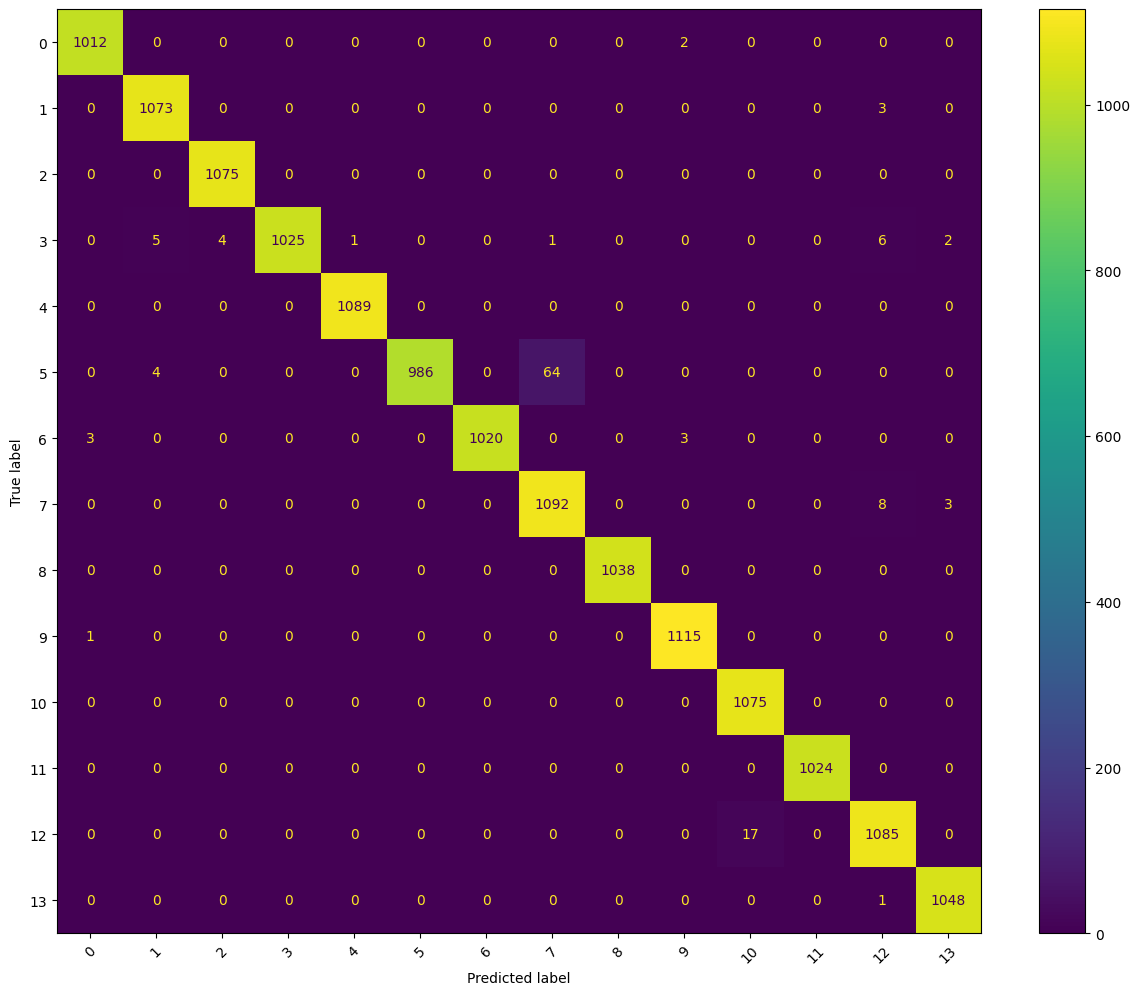

In [643]:
# compute the confusion matrix 
cmlstm = confusion_matrix(y_test_labels, y_pred_lstm_labels)

disp = ConfusionMatrixDisplay(confusion_matrix = cmlstm, display_labels = np.unique(y_test_labels))

plt.figure(figsize=(15,12))

x= disp.plot(values_format = 'd', ax = plt.gca())
plt.xticks(rotation = 45)

# save figure
plt.savefig(os.path.join(image_folder, "LSTM_confusion_matrix.png"))
plt.show()

In [644]:
print(classification_report( y_test_labels, y_pred_lstm_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1014
           1       0.99      1.00      0.99      1076
           2       1.00      1.00      1.00      1075
           3       1.00      0.98      0.99      1044
           4       1.00      1.00      1.00      1089
           5       1.00      0.94      0.97      1054
           6       1.00      0.99      1.00      1026
           7       0.94      0.99      0.97      1103
           8       1.00      1.00      1.00      1038
           9       1.00      1.00      1.00      1116
          10       0.98      1.00      0.99      1075
          11       1.00      1.00      1.00      1024
          12       0.98      0.98      0.98      1102
          13       1.00      1.00      1.00      1049

    accuracy                           0.99     14885
   macro avg       0.99      0.99      0.99     14885
weighted avg       0.99      0.99      0.99     14885



the model is already achieve 100% accuracy and 100 on F1 score, so no need to perform Hyperparameter tuning for this model

In [651]:
# calling the update score card method to update the score with this model
update_score_card(y_test_labels, y_pred_lstm_labels, 'LSTM_model')

### evaluate the model on the upgrad test data

In [654]:
# tokenize the texts :

ugttexts = ugt['clean_description'].values
ugtlabels = ugt_res['product_category_tree'].values

In [656]:
# convert labels to numeric format
unique_labels = list(set(ugtlabels))
label_mapping = {label : idx for idx, label in enumerate(unique_labels)}
numeric_labels = np.array(ugtlabels) # no need to map them

In [658]:
# Check for unexpected values in labels 
print('unique labels in dataset :', set(ugtlabels))
print('Label mapping dictionary :', label_mapping)

unique labels in dataset : {'Toys & School Supplies ', 'Kitchen & Dining ', 'Home Decor & Festive Needs ', 'Baby Care ', 'Mobiles & Accessories ', 'Pens & Stationery ', 'Jewellery ', 'Watches ', 'Footwear ', 'Automotive ', 'Bags, Wallets & Belts ', 'Tools & Hardware ', 'Computers ', 'Clothing '}
Label mapping dictionary : {'Toys & School Supplies ': 0, 'Kitchen & Dining ': 1, 'Home Decor & Festive Needs ': 2, 'Baby Care ': 3, 'Mobiles & Accessories ': 4, 'Pens & Stationery ': 5, 'Jewellery ': 6, 'Watches ': 7, 'Footwear ': 8, 'Automotive ': 9, 'Bags, Wallets & Belts ': 10, 'Tools & Hardware ': 11, 'Computers ': 12, 'Clothing ': 13}


In [660]:
x_train_seq = pad_sequences(tokenizer.texts_to_sequences(ugt['clean_description']), maxlen = max_length, padding='post')

In [662]:
x_test_seq

array([[  19,    1,  192, ...,    0,    0,    0],
       [2124,  985, 3877, ...,    0,    0,    0],
       [   3,  138,  133, ...,    0,    0,    0],
       ...,
       [1534, 1535,   72, ...,    0,    0,    0],
       [   1,   30,  941, ...,    0,    0,    0],
       [5549,  106,  146, ...,    0,    0,    0]])

In [664]:
ugt_res.head()

product_category_tree
0              Jewellery 
1              Jewellery 
2  Mobiles & Accessories 
3              Jewellery 
4              Jewellery

In [666]:
ugt_resarr

array(['Jewellery ', 'Jewellery ', 'Mobiles & Accessories ', ...,
       'Baby Care ', 'Baby Care ', 'Baby Care '], dtype=object)

In [668]:
# Encoding :
label_encoder = LabelEncoder()

# fit and transform the data
integer_encoder = label_encoder.fit_transform(ugt_res['product_category_tree'])


In [670]:
# one-hot encoding 
y_test_cat = to_categorical(integer_encoder, num_classes = len(unique_labels))

In [672]:
y_test_cat.shape

(2534, 14)

In [719]:
x_test_seq = x_test_seq[:len(y_test_cat)]

In [721]:
loss, accuracy = lstm_model.evaluate(x_test_seq, y_test_cat, verbose=1)
print(f'Test Accuracy : {accuracy:.4f}')

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0674 - loss: 11.9348
Test Accuracy : 0.0687


In [723]:
# generate prediction from the trained LSTM model for the test dataset
y_pred_lstm = lstm_model.predict(x_test_seq)

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [716]:
# looking at the predictions
y_pred_lstm

array([[3.1055103e-07, 8.3630075e-06, 9.9817691e-05, ..., 1.0907101e-08,
        2.3566373e-04, 8.4031220e-05],
       [6.8051833e-08, 8.6500258e-06, 1.9137353e-07, ..., 1.4084735e-08,
        7.4484415e-05, 5.0995167e-04],
       [9.9992537e-01, 4.7626192e-09, 4.2431250e-09, ..., 2.4091360e-08,
        1.0543078e-08, 6.1705081e-09],
       ...,
       [7.6352103e-07, 2.0674280e-07, 2.6667821e-09, ..., 9.9992764e-01,
        1.2515203e-07, 2.3229330e-08],
       [5.2729951e-07, 6.0695538e-06, 1.3369916e-04, ..., 3.2329147e-08,
        5.4062065e-04, 6.2714325e-04],
       [6.6712218e-08, 8.6368755e-06, 1.8308592e-07, ..., 1.4345348e-08,
        7.1569681e-05, 4.9510429e-04]], dtype=float32)

In [682]:
# convert the predicted probabilities to class labels
y_pred_lstm_labels = np.argmax(y_pred_lstm, axis =1)

y_pred_lstm_labels

array([ 3,  7,  0, ..., 11,  3,  7], dtype=int64)

In [684]:
y_test_cat

y_test_labels = np.argmax(y_test_cat, axis=1)

In [686]:
# Accuracy

In [694]:
y_pred_lstm_labels = y_pred_lstm_labels[:len(y_test_labels)]

In [696]:
accuracy_score(y_test_labels, y_pred_lstm_labels)

0.06866614048934491

classification report & F1 score

In [698]:
print(classification_report( y_test_labels, y_pred_lstm_labels))

              precision    recall  f1-score   support

           0       0.04      0.09      0.06        75
           1       0.10      0.07      0.08       259
           2       0.03      0.05      0.03       107
           3       0.33      0.06      0.10       882
           4       0.03      0.13      0.05        47
           5       0.05      0.06      0.05       144
           6       0.06      0.05      0.05       215
           7       0.11      0.07      0.08       313
           8       0.03      0.14      0.04        37
           9       0.14      0.08      0.10       331
          10       0.02      0.08      0.04        49
          11       0.00      0.00      0.00        12
          12       0.05      0.15      0.08        59
          13       0.01      0.25      0.01         4

    accuracy                           0.07      2534
   macro avg       0.07      0.09      0.06      2534
weighted avg       0.17      0.07      0.08      2534



In [700]:
# fit the encoder on your original categorical labels
label_encoder.fit(ugtlabels)

# now, to convert your numric predictions back to categorical
y_pred_lstm_labels = label_encoder.inverse_transform(y_pred_lstm_labels)

In [702]:
y_pred_lstm_labels

array(['Clothing ', 'Jewellery ', 'Automotive ', ...,
       'Pens & Stationery ', 'Computers ', 'Watches '], dtype=object)

In [704]:
# create a Dataframe from the predictions 
results_df = pd.DataFrame({
    'Predicted labels' : y_pred_lstm_labels
})

In [706]:
# Save to CSV
results_df.to_csv('predictions.csv', index= False)

* This model is performing well on test_result data

#### performance comparisons

In [710]:
# sort the score card by accuracy score in descending order
sorted_score_card = score_card.sort_values(by='F1 Score', ascending = False).reset_index(drop= True)
# store the top 5 model into final_score_card
final_score_card = sorted_score_card.head()
final_score_card

model_name  Accuracy Score  Precision Score  Recall Score  F1 Score
0   RFC_model        0.998656         0.998658      0.998656  0.998656
1  LSTM_model        0.997716         0.997737      0.997716  0.997714
2  LSTM_model        0.997649         0.997650      0.997649  0.997648
3  LSTM_model        0.991401         0.991631      0.991401  0.991386
4  LSTM_model        0.991401         0.991631      0.991401  0.991386

# Final Conclusion:

After evaluating multiple machine learning models and a deep learning model for the task of e-commerce product categorization, we found that the machine learning models, specifically the Random Forest and Logistic Regression, not performed well in terms of validation accuracy. Therefore, the Deep Learning model (LSTM) is recommended for the task of e-commerce product categorization.